## Эксперимент

Данный эксперимент был взят из консультации и доработан. Была добавлена подготовка признаков методом быстрых трансформаций Фурье (scipy.fft). Также, для минимации "взрыва" градиента, было использовано шкалирование выбранных признаков. Модель была переписана: вместо генератора использовал предобработку, так как мне было важно переиспользовать фичи в случае, если сессия Colab прервется. С генератором набора данных обучение проходило очень медленно и было трудно экспериментировать с гиперпараметрами нейросети. Поэтому я подготовил фичи заранее и сохранил  на всякий случай в csv. Выборку фичей решил провести позже, но в конечном счете меня устроил полный набор.

Итог: kaggle выдал скоринг 0.9963, хотя валидационная выборка показала результат 0.9290

### Подготовка к заданию

In [ ]:
!pip install kaggle tensorflow scipy==1.4.1

In [ ]:
!echo '{"username":"rafaelkamashev","key":"eab3ee5ba2be6c7e65d5fce267f5e70b"}' > kaggle.json

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
#!mkdir /root/.kaggle
#!cp -f '/content/kaggle.json' /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cian-datafest-2019

 87% 82.0M/94.4M [00:00<00:00, 89.0MB/s]
100% 94.4M/94.4M [00:00<00:00, 114MB/s] 
 82% 51.0M/62.0M [00:00<00:00, 41.8MB/s]
100% 62.0M/62.0M [00:00<00:00, 67.2MB/s]
 85% 26.0M/30.5M [00:00<00:00, 50.4MB/s]
100% 30.5M/30.5M [00:00<00:00, 77.2MB/s]


In [ ]:
!unzip -n cian-datafest-2019.zip
!unzip -n cian_datafest.zip
!unzip -n test.zip
#!unzip -n /content/test.zip
#!unzip -n /content/train.zip

In [ ]:
import glob

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import PIL
from PIL import ImageCms, ImageOps
import scipy as sp
from scipy.ndimage import convolve
from scipy.fft import fft2, fftfreq
from scipy.stats import moment, describe
import tensorflow as tf

In [ ]:
RAND_SEED = 255
np.random.seed(RAND_SEED)

Этапы подготовки признаков:

1. Чтение изображений из формата jpeg в numpy
2. Извлечение показателей освещенности (преобразование в LAB, извлечение среднего, отклонения, квантилей из L канала)
3. Извлечение характеристик вертикальных и горизонтальных линий (сверточные фильтры или гистограмма с пиками)
4. Получение цветовой гистограммы
5. Получение HOG (гистограммы направленных градиентов)
6. Статистика по FFT (быстрым преобразваниям Фурье)
7. Создание и обучение модели (полносвязная сеть)
8. Выгрузка результатов

### 1. Чтение изображений из формата jpeg в numpy

In [ ]:
indoor = [filename for filename in glob.glob('/content/datafest/indoor/*.jpg')]
outdoor = [filename for filename in glob.glob('/content/datafest/outdoor/*.jpg')]
print('Train files', len(indoor + outdoor))

Train files 82982


In [ ]:
def read_img(path, is_grayscale=False):
  """Читает изображение и преобразует в LAB или оттенки серого"""

  img = PIL.Image.open(path).convert('RGB')

  if is_grayscale:
    img = ImageOps.grayscale(img)

  return np.array(img)

In [ ]:
train_image_paths = outdoor + indoor
print('Train length', len(train_image_paths))

Train length 82982


### Показатели освещенности

In [ ]:
def rgb_to_lab(input_сolor):
	"""Преобразование цветовых каналов RBG в L (первый канал LAB)"""

	RGB = [0, 0, 0]
	for i in range(0, 3):
		RGB[i] = input_сolor[i] / 255.0

	X = RGB[0] * 0.4124 + RGB[1] * 0.3576 + RGB[2] * 0.1805
	Y = RGB[0] * 0.2126 + RGB[1] * 0.7152 + RGB[2] * 0.0722
	Z = RGB[0] * 0.0193 + RGB[1] * 0.1192 + RGB[2] * 0.9505

	XYZ = [X, Y, Z]
	XYZ[0] /= 95.045 / 100
	XYZ[1] /= 100.0 / 100
	XYZ[2] /= 108.875 / 100

	L = 0
	for i in range(0, 3):
		v=XYZ[i]

		if v > 0.008856:
			v = pow(v, 1.0 / 3)

			if i == 1:
				L = 116.0 * v - 16.0

		else:
			v *= 7.787
			v += 16.0 / 116

			if i == 1:
				L = 903.3 * XYZ[i]
		XYZ[i] = v

	return min(round(L), 100)

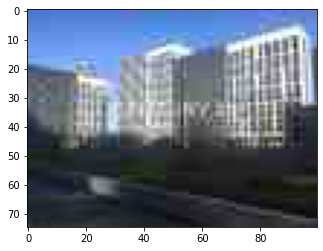

In [ ]:
img = read_img(train_image_paths[99])
plt.imshow(img);

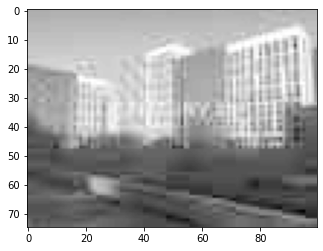

In [ ]:
L = np.apply_along_axis(rgb_to_lab, 2, img)
plt.imshow(L, 'gray');

In [ ]:
# Характеристики освещенности: моменты и статистика
L = img[:,:,0]
moments = [moment(L.flatten(), moment=i) for i in range(3, 6)]

def describe_sp(data):
  """Возвращает статистику освещенности"""

  descr_ = describe(data.flatten())
  # 1) минимум, 2) максимум, 3) среднее, 4) отклонение, 5) перекос, 6) эксцесс
  return [descr_.minmax[0], descr_.minmax[1], descr_.mean, descr_.variance, descr_.skewness, descr_.kurtosis]

stat_features = describe_sp(L)

In [ ]:
moments

[122974.74291021317, 27764109.89102649, 2496044429.72522]

In [ ]:
stat_features

[6,
 255,
 91.77226666666667,
 3316.1348221718445,
 0.6441018096569332,
 -0.47457069283292963]

In [ ]:
gray_scal = read_img(train_image_paths[10], is_grayscale=True)
gray_scal.shape

(100, 75)

### Характеристики вертикальных и горизонтальных линий

In [ ]:
# применяем сверточноя ядро Фарида
p = np.array([[0.0376593171958126, 0.249153396177344, 0.426374573253687,
               0.249153396177344, 0.0376593171958126]])
d1 = np.array([[0.109603762960254, 0.276690988455557, 0, -0.276690988455557,
                -0.109603762960254]])
HFARID_WEIGHTS = d1.T * p
VFARID_WEIGHTS = np.copy(HFARID_WEIGHTS.T)

image = img.astype('float')
result_h = convolve(gray_scal, HFARID_WEIGHTS)
result_v = convolve(gray_scal, VFARID_WEIGHTS)

h_features = describe_sp(result_h)[2:]
v_features = describe_sp(result_v)[2:]

In [ ]:
h_features

[119.3764, 14986.688148126417, 0.1078332496424696, -1.9743255521971186]

In [ ]:
v_features

[84.9816, 13308.961389625283, 0.7086674284033593, -1.4776327914151663]

### Цветовая гистограмма

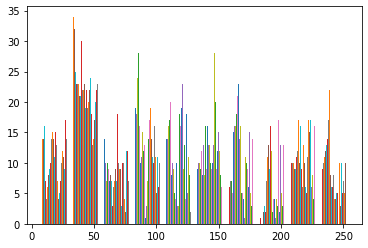

In [ ]:
plt.hist(img[:,:,0], bins=10);
plt.hist(img[:,:,1], bins=10);
plt.hist(img[:,:,2], bins=10);

In [ ]:
r = np.histogram(img[:,:,0], bins=20)
g = np.histogram(img[:,:,1], bins=20)
b = np.histogram(img[:,:,2], bins=20)

hist_ = sum([r[0], g[0], b[0]]) / 3.
hist_

array([  99.        ,  646.66666667, 1272.33333333,  668.66666667,
        303.66666667,  255.33333333,  310.66666667,  372.        ,
        481.66666667,  413.        ,  338.66666667,  377.        ,
        353.66666667,  308.66666667,  246.33333333,  215.        ,
        230.66666667,  248.        ,  179.        ,  180.        ])

### HOG (гистограмма направленных градиентов)

In [ ]:
cell = [8, 8]
incr = [8, 8]
bin_num = 8

#uses a [-1 0 1 kernel]
def create_grad_array(image_array):
	# gamma correction
	image_array = image_array ** 2.5

	# local contrast normalization
	image_array = (image_array - np.mean(image_array)) / np.std(image_array)
	max_h = image_array.shape[0]
	max_w = image_array.shape[1]

	grad = np.zeros([max_h, max_w])
	mag = np.zeros([max_h, max_w])

	for h,row in enumerate(image_array):
		for w, val in enumerate(row):
			if h - 1 >= 0 and w - 1 >= 0 and h + 1 < max_h and w + 1 < max_w:
				dy = image_array[h + 1][w] - image_array[h - 1][w]
				dx = row[w + 1]-row[w - 1] + 0.0001
				grad[h][w] = np.arctan(dy / dx) * (180 / np.pi)
				if grad[h][w] < 0:
					grad[h][w] += 180
				mag[h][w] = np.sqrt(dy * dy + dx * dx)
	
	return grad, mag


def calculate_histogram(array, weights):
	bins = bin_num
	hist, _ = np.histogram(array, bins=bins, range=(0, 180), weights=weights)

	return hist

def create_hog_features(grad_array, mag_array):
	max_h = int(((grad_array.shape[0] - cell[0]) / incr[0]) + 1)
	max_w = int(((grad_array.shape[1] - cell[1]) / incr[1]) + 1)
	cell_array = []
	w = 0
	h = 0
	i = 0
	j = 0

	#Creating 8X8 cells
	while i<max_h:
		w = 0
		j = 0

		while j < max_w:
			for_hist = grad_array[h:h + cell[0], w:w + cell[1]]
			for_wght = mag_array[h:h + cell[0], w:w + cell[1]]
			
			val = calculate_histogram(for_hist, for_wght)
			cell_array.append(val)
			j += 1
			w += incr[1]

		i += 1
		h += incr[0]

	cell_array = np.reshape(cell_array, (max_h, max_w, bin_num))
	#normalising blocks of cells
	block = [2, 2]
	#here increment is 1

	max_h = int((max_h-block[0]) + 1)
	max_w = int((max_w-block[1]) + 1)
	block_list = []
	w = 0
	h = 0
	i = 0
	j = 0

	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_norm = cell_array[h:h + block[0], w:w + block[1]]
			mag = np.linalg.norm(for_norm)
			arr_list = (for_norm / mag).flatten().tolist()
			block_list += arr_list
			j += 1
			w += 1

		i += 1
		h += 1

	#returns a vextor array list of 288 elements
	return block_list

#image_array must be an array
#returns a 288 features vector from image array
def apply_hog(image_array):
	gradient, magnitude = create_grad_array(image_array)
	hog_features = create_hog_features(gradient, magnitude)
	hog_features = np.asarray(hog_features, dtype=float)
	hog_features = np.expand_dims(hog_features, axis=0)

	return hog_features

In [ ]:
img_grayscale = read_img(train_image_paths[99], is_grayscale=True)
# HOG (historgamm of oriented gradients)
hog_features = apply_hog(img_grayscale)
hog_features.shape

(1, 2816)

### Статистика по FFT (быстрым преобразваниям Фурье)

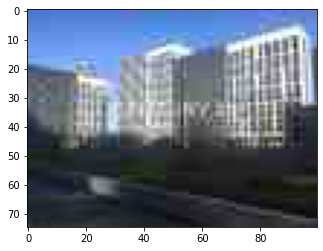

In [ ]:
# еще раз отрисуем пример
img = read_img(train_image_paths[99])
plt.imshow(img)

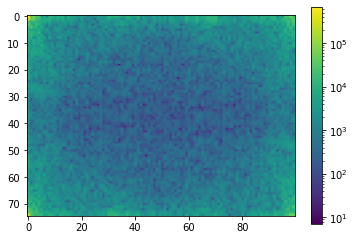

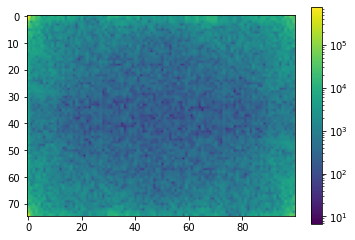

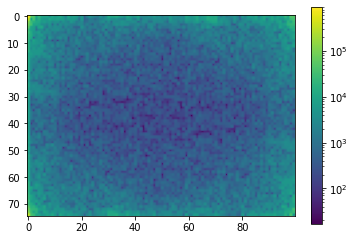

In [ ]:
channels = [x.reshape(*x.shape[:2]) for x in np.split(img, 3, axis=2)]
ffts = []
for channel in channels:
  fft_ = fft2(channel)
  plt.imshow(np.abs(fft_), norm=LogNorm())
  ffts.append(fft_)
  plt.colorbar()
  plt.show()

[7.052402346832724, 688292.0, 1559.0030495292772, 85614736.78979704, 59.396996387331065, 4165.293841922111]


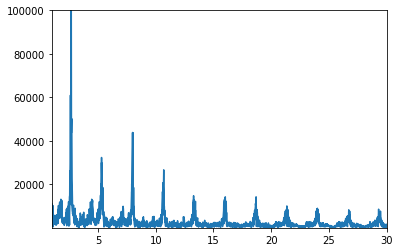

[6.613360866004208, 781701.0, 1602.5094816187707, 107509372.94438118, 61.32209186606944, 4381.161507878104]


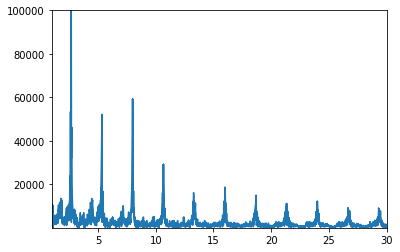

[16.59126299915874, 925586.0, 1743.106559581716, 156657249.15516388, 58.81662213514781, 4084.0235064077106]


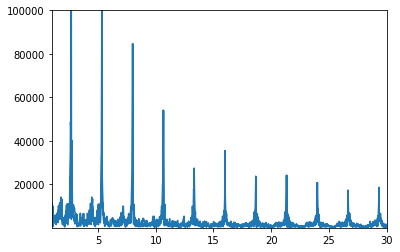

In [ ]:
# думаю, 1/2 пикселя будет достаточно в качестве частоты дискретизации
xf = fftfreq(img.shape[0] * img.shape[1], 1 / 200)

for fft_ in ffts:
  print(describe_sp(np.abs(fft_)))
  # можно взять только положительные значения, так как волны симметричные, 
  # а по оси y оставлю как есть, чтобы увеличить масштаб
  plt.plot(np.abs(xf), np.abs(fft_).flatten())
  plt.xlim(1, 30)
  plt.ylim(1, 100000)
  plt.show()

Частоты по каналам отличаются незначительно, но на некоторых примерах немного отличаются, поэтому решил взять по каналам по отдельности

## Обучение модели

### Создание и обучение модели (полносвязная нейросеть)

In [ ]:
# финальные функции извлечения фичей

def read_img(path, is_grayscale=False):
  img = PIL.Image.open(path).convert('RGB').resize(size=(70, 70))

  if is_grayscale:
    img = ImageOps.grayscale(img)
  return np.array(img)


def get_features(img_path):
  features = []
  data_rgb = read_img(img_path, is_grayscale=False)
  data_grayscale = read_img(img_path, is_grayscale=True)

  L = np.apply_along_axis(rgb_to_lab, 2, data_rgb)
  moments = [moment(L.flatten(), moment=i) for i in range(3, 6)]
  features.extend(moments)

  l_stat = describe_sp(L)
  features.extend(l_stat)      

  result_h = convolve(data_grayscale, HFARID_WEIGHTS)
  result_v = convolve(data_grayscale, VFARID_WEIGHTS)

  h_features = describe_sp(result_h)[2:]
  v_features = describe_sp(result_v)[2:]
  features.extend(h_features)
  features.extend(v_features)

  img = data_rgb.astype('float')
  R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
  r_hist = np.histogram(R, bins=20)
  g_hist = np.histogram(G, bins=20)
  b_hist = np.histogram(B, bins=20)

  hist_ = sum([r_hist[0], g_hist[0], b_hist[0]]) / 3. 
  features.extend(hist_)

  for channel in (R, G, B):
    fft_ = sp.fft.ifft2(channel)
    features.extend(describe_sp(np.abs(fft_))[2:])

  hog_ = apply_hog(data_grayscale)
  hog_features = describe_sp(hog_)
  features.extend(hog_features)
  features.extend(hog_.flatten().tolist())

  return np.array(features)

In [ ]:
# получение тренировочных данных
positive = glob.glob("/content/datafest/outdoor/*.jpg") # 1
negative = glob.glob("/content/datafest/indoor/*.jpg") # 0

x_paths = np.concatenate([positive, negative])
y = np.concatenate([
  np.ones(shape=(len(positive)), dtype=np.int32),
  np.zeros(shape=len(negative), dtype=np.int32)
], axis=0)
x_paths.shape, y.shape

((82982,), (82982,))

In [ ]:
%%time
# подготовим фичи по всей тренировочной выборке
x = []
for i, img_path in enumerate(x_paths):
  if i % 50 == 0:
    print(i, img_path)
  features = get_features(img_path=img_path)
  x.append(features)

x = np.array(x)

0 datafest/outdoor/image_71212.jpg
50 datafest/outdoor/image_34982.jpg
100 datafest/outdoor/image_75327.jpg
150 datafest/outdoor/image_11296.jpg
200 datafest/outdoor/image_57742.jpg
250 datafest/outdoor/image_34938.jpg
300 datafest/outdoor/image_24188.jpg
350 datafest/outdoor/image_5880.jpg
400 datafest/outdoor/image_47535.jpg
450 datafest/outdoor/image_39423.jpg
500 datafest/outdoor/image_7319.jpg
550 datafest/outdoor/image_69790.jpg
600 datafest/outdoor/image_4167.jpg
650 datafest/outdoor/image_74617.jpg
700 datafest/outdoor/image_81183.jpg
750 datafest/outdoor/image_3481.jpg
800 datafest/outdoor/image_565.jpg
850 datafest/outdoor/image_52979.jpg
900 datafest/outdoor/image_38761.jpg
950 datafest/outdoor/image_16884.jpg
1000 datafest/outdoor/image_73169.jpg
1050 datafest/outdoor/image_63554.jpg
1100 datafest/outdoor/image_49348.jpg
1150 datafest/outdoor/image_49500.jpg
1200 datafest/outdoor/image_17844.jpg
1250 datafest/outdoor/image_9296.jpg
1300 datafest/outdoor/image_48362.jpg
1350

10850 datafest/outdoor/image_61595.jpg
10900 datafest/outdoor/image_13182.jpg
10950 datafest/outdoor/image_70661.jpg
11000 datafest/outdoor/image_2449.jpg
11050 datafest/outdoor/image_79797.jpg
11100 datafest/outdoor/image_34752.jpg
11150 datafest/outdoor/image_53537.jpg
11200 datafest/outdoor/image_45941.jpg
11250 datafest/outdoor/image_70996.jpg
11300 datafest/outdoor/image_61670.jpg
11350 datafest/outdoor/image_12940.jpg
11400 datafest/outdoor/image_10085.jpg
11450 datafest/outdoor/image_68111.jpg
11500 datafest/outdoor/image_22122.jpg
11550 datafest/outdoor/image_44968.jpg
11600 datafest/outdoor/image_23598.jpg
11650 datafest/outdoor/image_81650.jpg
11700 datafest/outdoor/image_59093.jpg
11750 datafest/outdoor/image_21495.jpg
11800 datafest/outdoor/image_9909.jpg
11850 datafest/outdoor/image_25796.jpg
11900 datafest/outdoor/image_61497.jpg
11950 datafest/outdoor/image_32483.jpg
12000 datafest/outdoor/image_37751.jpg
12050 datafest/outdoor/image_78917.jpg
12100 datafest/outdoor/imag

21400 datafest/outdoor/image_60113.jpg
21450 datafest/outdoor/image_61605.jpg
21500 datafest/outdoor/image_18758.jpg
21550 datafest/outdoor/image_71045.jpg
21600 datafest/outdoor/image_30477.jpg
21650 datafest/outdoor/image_62547.jpg
21700 datafest/outdoor/image_59398.jpg
21750 datafest/outdoor/image_7533.jpg
21800 datafest/outdoor/image_48259.jpg
21850 datafest/outdoor/image_34509.jpg
21900 datafest/outdoor/image_55531.jpg
21950 datafest/outdoor/image_67139.jpg
22000 datafest/outdoor/image_20642.jpg
22050 datafest/outdoor/image_4385.jpg
22100 datafest/outdoor/image_47532.jpg
22150 datafest/outdoor/image_1276.jpg
22200 datafest/outdoor/image_73992.jpg
22250 datafest/outdoor/image_50536.jpg
22300 datafest/outdoor/image_36616.jpg
22350 datafest/outdoor/image_25623.jpg
22400 datafest/outdoor/image_5268.jpg
22450 datafest/outdoor/image_74836.jpg
22500 datafest/outdoor/image_24906.jpg
22550 datafest/outdoor/image_36914.jpg
22600 datafest/outdoor/image_47542.jpg
22650 datafest/outdoor/image_

31950 datafest/outdoor/image_45962.jpg
32000 datafest/outdoor/image_71982.jpg
32050 datafest/outdoor/image_68992.jpg
32100 datafest/outdoor/image_8523.jpg
32150 datafest/outdoor/image_76416.jpg
32200 datafest/outdoor/image_48825.jpg
32250 datafest/outdoor/image_81007.jpg
32300 datafest/outdoor/image_74702.jpg
32350 datafest/outdoor/image_30924.jpg
32400 datafest/outdoor/image_72631.jpg
32450 datafest/outdoor/image_29896.jpg
32500 datafest/outdoor/image_12416.jpg
32550 datafest/outdoor/image_59870.jpg
32600 datafest/outdoor/image_67340.jpg
32650 datafest/outdoor/image_4958.jpg
32700 datafest/outdoor/image_71501.jpg
32750 datafest/outdoor/image_65885.jpg
32800 datafest/outdoor/image_12688.jpg
32850 datafest/outdoor/image_57488.jpg
32900 datafest/outdoor/image_33281.jpg
32950 datafest/outdoor/image_57983.jpg
33000 datafest/outdoor/image_14328.jpg
33050 datafest/outdoor/image_7141.jpg
33100 datafest/outdoor/image_30394.jpg
33150 datafest/outdoor/image_74057.jpg
33200 datafest/outdoor/image

42550 datafest/indoor/image_56892.jpg
42600 datafest/indoor/image_10734.jpg
42650 datafest/indoor/image_20980.jpg
42700 datafest/indoor/image_16143.jpg
42750 datafest/indoor/image_68286.jpg
42800 datafest/indoor/image_59845.jpg
42850 datafest/indoor/image_21955.jpg
42900 datafest/indoor/image_21280.jpg
42950 datafest/indoor/image_42033.jpg
43000 datafest/indoor/image_70766.jpg
43050 datafest/indoor/image_9491.jpg
43100 datafest/indoor/image_73598.jpg
43150 datafest/indoor/image_177.jpg
43200 datafest/indoor/image_10034.jpg
43250 datafest/indoor/image_53187.jpg
43300 datafest/indoor/image_33725.jpg
43350 datafest/indoor/image_49976.jpg
43400 datafest/indoor/image_24884.jpg
43450 datafest/indoor/image_26793.jpg
43500 datafest/indoor/image_20000.jpg
43550 datafest/indoor/image_44267.jpg
43600 datafest/indoor/image_24954.jpg
43650 datafest/indoor/image_39087.jpg
43700 datafest/indoor/image_36087.jpg
43750 datafest/indoor/image_16994.jpg
43800 datafest/indoor/image_11403.jpg
43850 datafest/

53400 datafest/indoor/image_39546.jpg
53450 datafest/indoor/image_79762.jpg
53500 datafest/indoor/image_17284.jpg
53550 datafest/indoor/image_21200.jpg
53600 datafest/indoor/image_12768.jpg
53650 datafest/indoor/image_64038.jpg
53700 datafest/indoor/image_80949.jpg
53750 datafest/indoor/image_5832.jpg
53800 datafest/indoor/image_75529.jpg
53850 datafest/indoor/image_50991.jpg
53900 datafest/indoor/image_32130.jpg
53950 datafest/indoor/image_37360.jpg
54000 datafest/indoor/image_50393.jpg
54050 datafest/indoor/image_75539.jpg
54100 datafest/indoor/image_41862.jpg
54150 datafest/indoor/image_80280.jpg
54200 datafest/indoor/image_46305.jpg
54250 datafest/indoor/image_79053.jpg
54300 datafest/indoor/image_30927.jpg
54350 datafest/indoor/image_3278.jpg
54400 datafest/indoor/image_36602.jpg
54450 datafest/indoor/image_25569.jpg
54500 datafest/indoor/image_60732.jpg
54550 datafest/indoor/image_6658.jpg
54600 datafest/indoor/image_75456.jpg
54650 datafest/indoor/image_49604.jpg
54700 datafest/

64250 datafest/indoor/image_71802.jpg
64300 datafest/indoor/image_17937.jpg
64350 datafest/indoor/image_62420.jpg
64400 datafest/indoor/image_7872.jpg
64450 datafest/indoor/image_18422.jpg
64500 datafest/indoor/image_10320.jpg
64550 datafest/indoor/image_60902.jpg
64600 datafest/indoor/image_1853.jpg
64650 datafest/indoor/image_22119.jpg
64700 datafest/indoor/image_41270.jpg
64750 datafest/indoor/image_52515.jpg
64800 datafest/indoor/image_29062.jpg
64850 datafest/indoor/image_28041.jpg
64900 datafest/indoor/image_41945.jpg
64950 datafest/indoor/image_59102.jpg
65000 datafest/indoor/image_82748.jpg
65050 datafest/indoor/image_46142.jpg
65100 datafest/indoor/image_48484.jpg
65150 datafest/indoor/image_5051.jpg
65200 datafest/indoor/image_17688.jpg
65250 datafest/indoor/image_9485.jpg
65300 datafest/indoor/image_53167.jpg
65350 datafest/indoor/image_3875.jpg
65400 datafest/indoor/image_80405.jpg
65450 datafest/indoor/image_76126.jpg
65500 datafest/indoor/image_1662.jpg
65550 datafest/ind

75100 datafest/indoor/image_52805.jpg
75150 datafest/indoor/image_24024.jpg
75200 datafest/indoor/image_28661.jpg
75250 datafest/indoor/image_75433.jpg
75300 datafest/indoor/image_74879.jpg
75350 datafest/indoor/image_47153.jpg
75400 datafest/indoor/image_22324.jpg
75450 datafest/indoor/image_24054.jpg
75500 datafest/indoor/image_7967.jpg
75550 datafest/indoor/image_37119.jpg
75600 datafest/indoor/image_68627.jpg
75650 datafest/indoor/image_33760.jpg
75700 datafest/indoor/image_8534.jpg
75750 datafest/indoor/image_64539.jpg
75800 datafest/indoor/image_24291.jpg
75850 datafest/indoor/image_80751.jpg
75900 datafest/indoor/image_34723.jpg
75950 datafest/indoor/image_59462.jpg
76000 datafest/indoor/image_50347.jpg
76050 datafest/indoor/image_1284.jpg
76100 datafest/indoor/image_66994.jpg
76150 datafest/indoor/image_9181.jpg
76200 datafest/indoor/image_78042.jpg
76250 datafest/indoor/image_3605.jpg
76300 datafest/indoor/image_29038.jpg
76350 datafest/indoor/image_50228.jpg
76400 datafest/in

Очевидно, что не все метрики имеют одинаковый масштаб. Дабы избежать "взрыва" градиента, проведу шкалирование по ряду признаков

In [ ]:
# сохраню на случай, если сессия прервется
x_df = pd.DataFrame(x)
x_df.to_csv(f'/content/x_raw.csv', index=False)

y_df = pd.DataFrame(y)
y_df.to_csv(f'/content/y.csv', index=False)

del x_df, y_df

(82982, 1623)


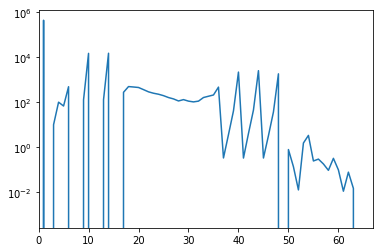

In [ ]:
# разбег значений в пределах 8 порядков - нужно шкалировать
plt.plot(x[0])
plt.xlim(0, 67);
plt.yscale("log")
print(x.shape)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalers = []
# HOG шкалировать большого смысла нет, там значения практически не выбиваются за 0...1
for feature in range(67):
  scaler = MinMaxScaler()
  x[:, feature] = scaler.fit_transform(x[:, feature].reshape(-1, 1)).reshape(-1)
  scalers.append(scaler)

(82982, 1623)


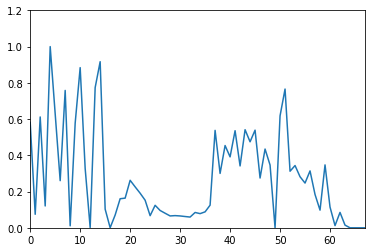

In [ ]:
# после шкалирования
plt.plot(x[0])
plt.xlim(0, 67);
plt.ylim(0, 1.2);
print(x.shape)

In [ ]:
# разбиваю выборку на тренировочную и валидационную (80/20)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=RAND_SEED
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape, y.shape[0] == y_train.shape[0] + y_test.shape[0]

((66385, 1623), (16597, 1623), (66385,), (16597,), True)

In [ ]:
# формирую модель. 2 скрытых слоя и дропаут, после чего 1 выходной нейрон с сигмоидной активацией 
# для отдачи вероятностного результата прогнозирования от 0 до 1, как требует соревнование
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(1623,)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('sigmoid'))

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               831488    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
 activation_2 (Activation)   (None, 1)                 0

2021-12-11 22:12:39.964242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-11 22:12:39.964280: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-11 22:12:39.964295: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wizzzet-HP-ProBook-430-G7): /proc/driver/nvidia/version does not exist
2021-12-11 22:12:39.965203: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# обучение модели
history = model.fit(
  x_train, y_train, batch_size=32, epochs=15, verbose=1
)

2021-12-11 22:12:54.115014: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 430971420 exceeds 10% of free system memory.


Epoch 1/15
2075/2075 [==============================] - 12s 5ms/step - loss: 0.2837 - accuracy: 0.8826
Epoch 2/15
2075/2075 [==============================] - 14s 7ms/step - loss: 0.2099 - accuracy: 0.9177
Epoch 3/15
2075/2075 [==============================] - 13s 6ms/step - loss: 0.1793 - accuracy: 0.9309
Epoch 4/15
2075/2075 [==============================] - 13s 6ms/step - loss: 0.1594 - accuracy: 0.9398
Epoch 5/15
2075/2075 [==============================] - 13s 6ms/step - loss: 0.1387 - accuracy: 0.9486
Epoch 6/15
2075/2075 [==============================] - 14s 7ms/step - loss: 0.1253 - accuracy: 0.9531
Epoch 7/15
2075/2075 [==============================] - 13s 6ms/step - loss: 0.1097 - accuracy: 0.9590
Epoch 8/15
2075/2075 [==============================] - 14s 7ms/step - loss: 0.0960 - accuracy: 0.9650
Epoch 9/15
2075/2075 [==============================] - 13s 6ms/step - loss: 0.0854 - accuracy: 0.9684
Epoch 10/15
2075/2075 [==============================] - 14s 7ms/step - l

In [ ]:
# проверка на валидационной выборке
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

 28/519 [>.............................] - ETA: 0s - loss: 0.2563 - accuracy: 0.9364 

2021-12-11 22:16:19.000104: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 107747724 exceeds 10% of free system memory.


519/519 [==============================] - 1s 2ms/step - loss: 0.3018 - accuracy: 0.9290
Test score: 0.3018335998058319
Test accuracy: 0.9290233254432678


## Предсказание на тестовой выборке

In [ ]:
!unzip -n test.zip

Archive:  test.zip


In [ ]:
%%time
# подготовка всех фичей аналогично тренировочной выборке
n_test, x_test_ = [], []
test_filenames = glob.glob('/content/test/*.jpg')

for i, img_path in enumerate(sorted(test_filenames)):
  if i % 50 == 0:
    print(i, img_path)

  # извлекаю порядковый номер каждого примера
  test_num = img_path.split('/')[-1].split('.')[0].replace('image_', '')
  n_test.append(test_num)

  features = get_features(img_path=img_path)
  x_test_.append(features)

x_test_ = np.array(x_test_)

0 test/0.jpg
50 test/10144.jpg
100 test/10332.jpg
150 test/10468.jpg
200 test/10583.jpg
250 test/10723.jpg
300 test/1085.jpg
350 test/11003.jpg
400 test/11137.jpg
450 test/11258.jpg
500 test/11393.jpg
550 test/11526.jpg
600 test/11650.jpg
650 test/11788.jpg
700 test/11944.jpg
750 test/12076.jpg
800 test/12203.jpg
850 test/12335.jpg
900 test/12479.jpg
950 test/1262.jpg
1000 test/12749.jpg
1050 test/12898.jpg
1100 test/13007.jpg
1150 test/13162.jpg
1200 test/13313.jpg
1250 test/13448.jpg
1300 test/1359.jpg
1350 test/13747.jpg
1400 test/13885.jpg
1450 test/14012.jpg
1500 test/14120.jpg
1550 test/14275.jpg
1600 test/14412.jpg
1650 test/14549.jpg
1700 test/14676.jpg
1750 test/14819.jpg
1800 test/14942.jpg
1850 test/15092.jpg
1900 test/15237.jpg
1950 test/15379.jpg
2000 test/15506.jpg
2050 test/15660.jpg
2100 test/1581.jpg
2150 test/15949.jpg
2200 test/16101.jpg
2250 test/16222.jpg
2300 test/16351.jpg
2350 test/16490.jpg
2400 test/16638.jpg
2450 test/16757.jpg
2500 test/16872.jpg
2550 test/1

20200 test/64542.jpg
20250 test/64689.jpg
20300 test/64827.jpg
20350 test/64974.jpg
20400 test/65107.jpg
20450 test/65253.jpg
20500 test/65375.jpg
20550 test/65520.jpg
20600 test/65667.jpg
20650 test/6581.jpg
20700 test/65949.jpg
20750 test/66121.jpg
20800 test/6624.jpg
20850 test/66391.jpg
20900 test/66518.jpg
20950 test/66669.jpg
21000 test/66813.jpg
21050 test/66952.jpg
21100 test/67122.jpg
21150 test/67242.jpg
21200 test/67352.jpg
21250 test/67489.jpg
21300 test/67613.jpg
21350 test/67728.jpg
21400 test/67871.jpg
21450 test/68010.jpg
21500 test/68160.jpg
21550 test/68320.jpg
21600 test/68469.jpg
21650 test/68623.jpg
21700 test/68748.jpg
21750 test/68879.jpg
21800 test/69009.jpg
21850 test/69139.jpg
21900 test/69282.jpg
21950 test/69423.jpg
22000 test/69540.jpg
22050 test/69665.jpg
22100 test/69790.jpg
22150 test/69913.jpg
22200 test/70043.jpg
22250 test/70181.jpg
22300 test/7032.jpg
22350 test/70457.jpg
22400 test/70610.jpg
22450 test/70764.jpg
22500 test/70912.jpg
22550 test/71060

In [ ]:
# нужно отшкалировать с теми же препроцессорами, что были созданы и настроены для тренировочного набора
for feature, scaler in enumerate(scalers):
  x_test_[:, feature] = scaler.transform(x_test_[:, feature].reshape(-1, 1)).reshape(-1)

In [ ]:
results = model.predict(x_test_)

2021-12-11 23:08:01.719220: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 179568720 exceeds 10% of free system memory.


In [ ]:
results.shape

(27660, 1)

### Выгрузка результатов

In [ ]:
# приготовлю к выгрузке в csv. На всякий случай приведу все к строке, чтобы было предсказуемо
y_pred = np.array(list(zip(
  n_test,
  ['{:10.10f}'.format(x) for x in results.flatten()]
)))
y_pred

array([['0', '0.0000000000'],
       ['1000', '0.9982105494'],
       ['10001', '1.0000000000'],
       ...,
       ['9985', '0.0000001025'],
       ['9988', '0.9844062328'],
       ['9992', '0.0007129312']], dtype='<U12')

In [ ]:
# сохраняю csv с результатом
y_pred_df = pd.DataFrame(y_pred, columns=['image_number', 'prob_outdoor'])
y_pred_df.to_csv(f'/content/cian_pred.csv', index=False)

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'/content/results.csv', index=False)

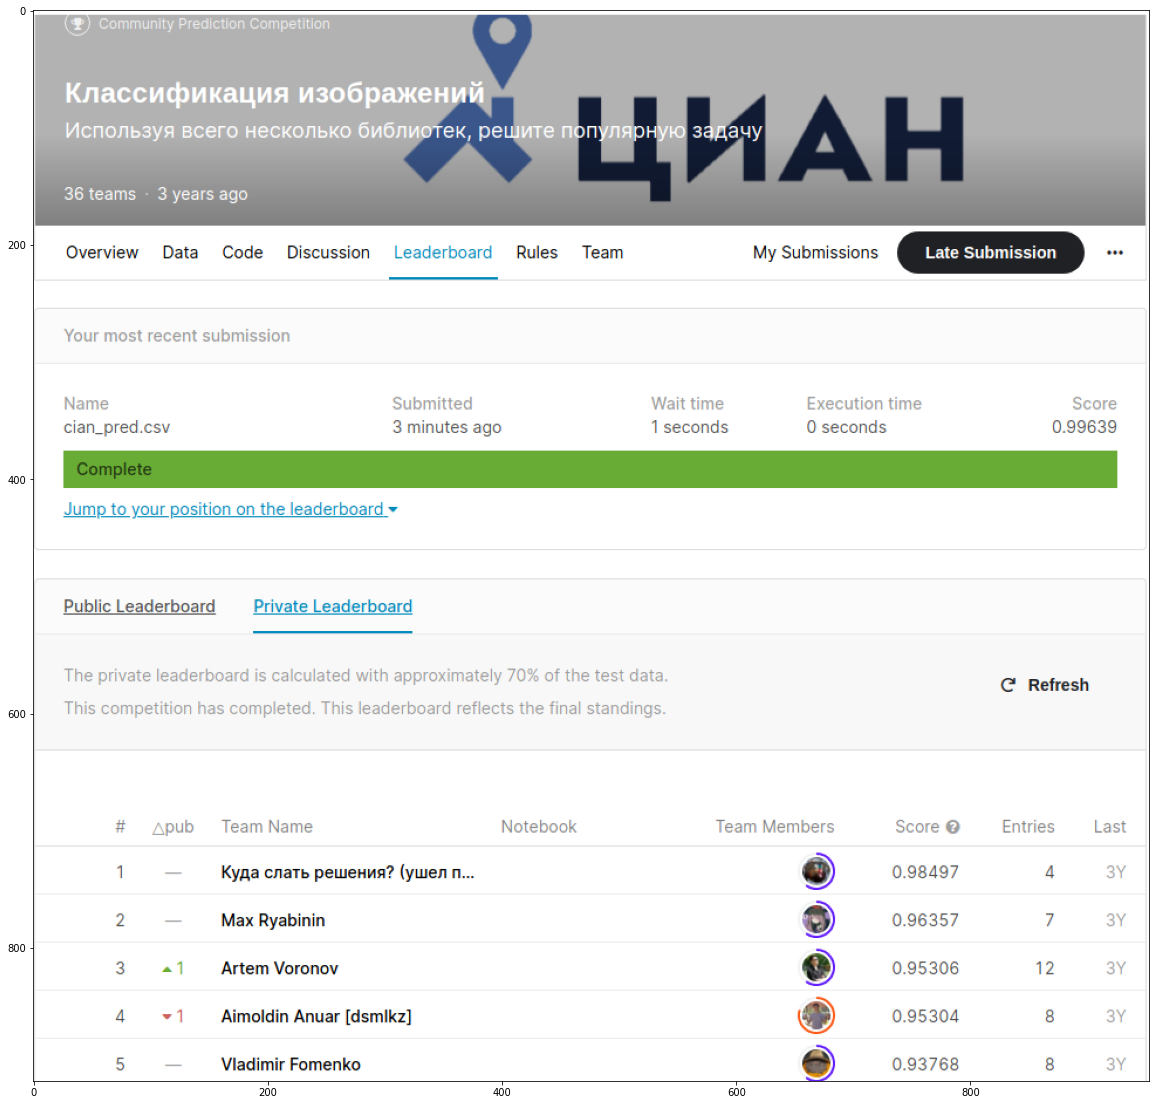

In [ ]:
# странный результат (выше, чем после тренировки и проверки на валидационной выборке. Но что есть, то есть)
img = PIL.Image.open('/content/screenshot.png').convert('RGB')
plt.figure(figsize=(20, 20))
plt.imshow(img)